In [1]:
from utility import *
import warnings
warnings.filterwarnings('ignore') 

In [2]:
from featurization import *
import pandas as pd 
import numpy as np


train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')
train_features, test_features, feature_names = featurize(train, test, 'tfidf_glove')

Starts with number....
Clickbait Phrases....
Clickbait re....
Num dots....
Text Features....
Punctuation....
Word ratios....
Sentiment Scores....
Readability Scores....



Glove.....



DONE!


In [3]:
y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)

# Dimensionality Reduction

As we discussed in the intro, the feature space becomes sparse as we increased the dimensionality of small datasets. This makes the classifeir easily overfit and the solution is simply to reduce the dimensionality. Two broad ways to do this are: Feature selection and Decomposition. 

## Feature Selection 

### `SelectKBest`

We'll start with `SelectKBest` which, as the name suggests, simply selects the k-best features based on the chosen statistic (by default ANOVA F-Scores)

In [89]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k = 80)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test)

F1: 0.958 | Pr: 0.946 | Re: 0.971 | AUC: 0.989 | Accuracy: 0.957 



SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
# Lets run a for loop to select the value of K that optimizes F1

f1_scores = []

for k in tqdm_notebook(range(1, train_features.shape[1])):
    selector = SelectKBest(k = k)
    train_features_selected = selector.fit_transform(train_features, y_train)
    test_features_selected = selector.transform(test_features)
    f1_scores.append(run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2, return_f1 = True, verbose = 0))
f1_scores = np.array(f1_scores)

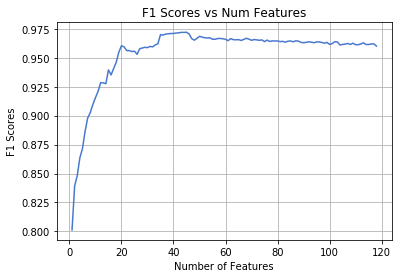

In [27]:
# Now let's plot the F1 scores:
import matplotlib.pyplot as plt

%matplotlib inline

x = list(range(1, train_features.shape[1]))
plt.plot(x, f1_scores)
plt.xlabel('Number of Features')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Num Features')
plt.grid()
plt.show()

As expected, the F1 score increases up to a certain point and then drops down a little. We can check the exact k value for which F1 is maximum.

In [28]:
print(np.argmax(f1_scores) + 1)

45


In [29]:
selector = SelectKBest(k = 45)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.972 | Pr: 0.967 | Re: 0.978 | AUC: 0.995 | Accuracy: 0.972 



SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
# we can use get_support() to find out exactly which features were selected
np.array(feature_names)[selector.get_support()]

array(['starts_with_number', 'easy_words_ratio', 'stop_words_ratio',
       'clickbait_subs_ratio', 'dale_chall_readability_score', 'glove_3',
       'glove_4', 'glove_6', 'glove_10', 'glove_14', 'glove_15',
       'glove_17', 'glove_19', 'glove_24', 'glove_27', 'glove_31',
       'glove_32', 'glove_33', 'glove_35', 'glove_39', 'glove_41',
       'glove_44', 'glove_45', 'glove_46', 'glove_49', 'glove_50',
       'glove_51', 'glove_56', 'glove_57', 'glove_61', 'glove_65',
       'glove_68', 'glove_72', 'glove_74', 'glove_75', 'glove_77',
       'glove_80', 'glove_85', 'glove_87', 'glove_90', 'glove_92',
       'glove_96', 'glove_97', 'glove_98', 'glove_99'], dtype='<U28')

A disadvantage of `SelectKBest` is that we manually need to select the number of features we want to keep. `SelectPercentile` does the same thing, except this time we can pass the percentage of features we want to keep.

### `SelectPercentile`

In [32]:
from sklearn.feature_selection import SelectPercentile

f1_scores = []

for percentage in tqdm_notebook(range(1, 101)):
    selector = SelectPercentile(percentile = percentage)
    train_features_selected = selector.fit_transform(train_features, y_train)
    test_features_selected = selector.transform(test_features)
    f1_scores.append(run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2, return_f1 = True, verbose = 0))
f1_scores = np.array(f1_scores)

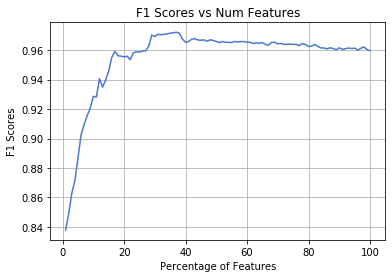

In [33]:
# Now let's plot the F1 scores:
import matplotlib.pyplot as plt

%matplotlib inline

x = list(range(1, 101))
plt.plot(x, f1_scores)
plt.xlabel('Percentage of Features')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Num Features')
plt.grid()
plt.show()

In [34]:
print(np.argmax(f1_scores) + 1)

37


In [43]:
selector = SelectPercentile(percentile = 37)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.972 | Pr: 0.966 | Re: 0.979 | AUC: 0.995 | Accuracy: 0.972 



SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
np.array(feature_names)[selector.get_support()]

array(['starts_with_number', 'easy_words_ratio', 'stop_words_ratio',
       'clickbait_subs_ratio', 'dale_chall_readability_score', 'glove_4',
       'glove_6', 'glove_10', 'glove_14', 'glove_15', 'glove_17',
       'glove_19', 'glove_24', 'glove_27', 'glove_31', 'glove_32',
       'glove_33', 'glove_35', 'glove_39', 'glove_41', 'glove_44',
       'glove_45', 'glove_46', 'glove_49', 'glove_50', 'glove_51',
       'glove_56', 'glove_57', 'glove_61', 'glove_65', 'glove_68',
       'glove_72', 'glove_74', 'glove_75', 'glove_77', 'glove_80',
       'glove_85', 'glove_87', 'glove_90', 'glove_92', 'glove_96',
       'glove_97', 'glove_98', 'glove_99'], dtype='<U28')

Looks like most of the features selected were the same between the two techniques.

### `RFECV` (Recursive Features Elimination)  

RFE is a backward feature selection technique that uses an estimator to calculate the feature importance at each stage. The word recursive in the name implies that the technique recursively removes features that are not important for classifiction. 

We'll use the CV variant which uses cross-validation inside each loop to determine how many features to remove in each loop. RFECV needs an estimator which has the `feature_importances_` attribute so we'll use SGDClassifier with log loss.

In [16]:
# Since we have a hold out Test set that we would like to use - Let's create a `PredefinedSplit`
from sklearn.model_selection import PredefinedSplit

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]     # We need to label -1 for the train set and 0 for test set
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

In [55]:
from sklearn.feature_selection import RFECV

log_reg = SGDClassifier(loss = 'log', alpha = 1e-3)

selector = RFECV(log_reg, scoring = 'f1', n_jobs = -1, cv = ps, verbose = 1)
selector.fit(X, y)

Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting 

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=1000, n_iter_no_change=5, n_jobs=None,
                              penalty='l2', power_t=0.5, random_state=None,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='f1', step=1, verbose=1)

In [56]:
# Now lets select the best features and check the performance
train_features_selected = selector.transform(train_features)
test_features_selected = selector.transform(test_features)

run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-1)

F1: 0.978 | Pr: 0.970 | Re: 0.986 | AUC: 0.997 | Accuracy: 0.978 



SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [57]:
# Lets check which features were selected 

print('Number of features selected : {}'.format(selector.n_features_))
np.array(feature_names)[selector.support_]

Number of features selected : 60


array(['starts_with_number', 'clickbait_phrases', 'num_dots',
       'mean_word_length', 'length_in_chars', 'easy_words_ratio',
       'stop_words_ratio', 'contractions_ratio', 'hyperbolic_ratio',
       'clickbait_subs_ratio', 'nonclickbait_subs_ratio',
       'num_punctuations', 'glove_1', 'glove_2', 'glove_4', 'glove_6',
       'glove_10', 'glove_13', 'glove_14', 'glove_15', 'glove_16',
       'glove_17', 'glove_21', 'glove_25', 'glove_27', 'glove_32',
       'glove_33', 'glove_35', 'glove_39', 'glove_41', 'glove_43',
       'glove_45', 'glove_46', 'glove_47', 'glove_50', 'glove_51',
       'glove_52', 'glove_53', 'glove_54', 'glove_56', 'glove_57',
       'glove_58', 'glove_61', 'glove_65', 'glove_72', 'glove_74',
       'glove_77', 'glove_80', 'glove_84', 'glove_85', 'glove_86',
       'glove_87', 'glove_90', 'glove_93', 'glove_94', 'glove_95',
       'glove_96', 'glove_97', 'glove_98', 'glove_99'], dtype='<U28')

This time some additional features were selected that gives a slight boost in performance. The advantage here is that we did not have to mention how many features to keep, `RFECV` automatically finds that out for us. However, we can mention the minimum number of features we'd like to have which by default is 1

### `SFS` (Sequential Forward Selection)

Finally, let's try `SFS` - which does the same thing as `RFE` instead adds features sequentially. `SFS` starts with 0 features and adds features 1-by-1 in each loop in a greedy manner. One small difference is that `SFS` solely uses the feature sets performance on the CV set as a metric for selecting the best features, unlike `RFE` which used model weights (`feature_importances_`)

In [56]:
# Note: MLxtend provides the SFS Implementation
from mlxtend.feature_selection import SequentialFeatureSelector

log_reg = SGDClassifier(loss = 'log', alpha = 1e-2)

selector = SequentialFeatureSelector(log_reg, k_features = 'best', floating = True, cv = ps, scoring = 'f1', verbose = 1, n_jobs = -1) # k_features = 'best' returns the best subset of features
selector.fit(X.tocsr(), y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    0.7s finished
Features: 1/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 2/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 co

Features: 20/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
Features: 21/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.1s finished
Features: 22/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8

[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.3s finished
Features: 40/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
Features: 41/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.3s finished
Features: 42/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurren

[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.4s finished
Features: 62/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    0.4s finished
Features: 63/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    0.5s finished
Features: 64/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:    0.5s finished
Features: 77/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    0.5s finished
Features: 78/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    0.5s finished
Features: 79/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Done  14 out of  29 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished
Features: 91/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  28 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished
Features: 91/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  28 | elapsed:    0.2s remaining

Features: 96/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  95 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    0.8s finished
Features: 96/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  23 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.9s finished
Features: 105/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 out of 103 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    0.8s finished
Features: 104/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finishe

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.9s finished
Features: 108/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    1.2s finished
Features: 108/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finishe

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    1.0s finished
Features: 113/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    1.0s finished
Features: 114/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    1.1s finished
Features: 114/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
Features: 118/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.1s finished
Features: 118/119[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.1s finished
Features: 119/119

SequentialFeatureSelector(clone_estimator=True,
                          cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                          estimator=SGDClassifier(alpha=0.01, average=False,
                                                  class_weight=None,
                                                  early_stopping=False,
                                                  epsilon=0.1, eta0=0.0,
                                                  fit_intercept=True,
                                                  l1_ratio=0.15,
                                                  learning_rate='optimal',
                                                  loss='log', max_iter=1000,
                                                  n_iter_no_change=5,
                                                  n_jobs=None, penalty='l2',
                                                  power_t=0.5,
                                                  random_state=None,
         

In [71]:
# Now lets select the best features and check the performance
train_features_selected = selector.transform(train_features.tocsr())
test_features_selected = selector.transform(test_features.tocsr())

run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.978 | Pr: 0.976 | Re: 0.981 | AUC: 0.997 | Accuracy: 0.978 



SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
print('Num of features selected : {}'.format(len(selector.k_feature_idx_)))
np.array(feature_names)[list(selector.k_feature_idx_)]

Num of features selected : 53


array(['starts_with_number', 'clickbait_phrases', 'mean_word_length',
       'length_in_chars', 'stop_words_ratio', 'nonclickbait_subs_ratio',
       'flesch_kincaid_grade', 'dale_chall_readability_score',
       'num_punctuations', 'glove_0', 'glove_1', 'glove_2', 'glove_4',
       'glove_8', 'glove_10', 'glove_13', 'glove_14', 'glove_15',
       'glove_16', 'glove_17', 'glove_18', 'glove_25', 'glove_30',
       'glove_32', 'glove_33', 'glove_38', 'glove_39', 'glove_40',
       'glove_41', 'glove_42', 'glove_45', 'glove_46', 'glove_47',
       'glove_48', 'glove_51', 'glove_56', 'glove_57', 'glove_61',
       'glove_65', 'glove_67', 'glove_69', 'glove_72', 'glove_73',
       'glove_76', 'glove_77', 'glove_80', 'glove_81', 'glove_84',
       'glove_85', 'glove_87', 'glove_93', 'glove_95', 'glove_96'],
      dtype='<U28')

# Decomposition

Unlike feature selection which picks the best features, decomposition techniques factorize the feature matrix to reduce the dimensionality. Since these techniques change the feature space itself, one disadvantage is that we lose model/feature interpretability. We no longer know what each dimension of the decomposed feature space represents. 

## `TruncatedSVD`

In [90]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(train_features.shape[1] - 1)
svd.fit(train_features)

TruncatedSVD(algorithm='randomized', n_components=118, n_iter=5,
             random_state=None, tol=0.0)

Text(0.5, 1.0, 'Number of Components vs Explained Variance')

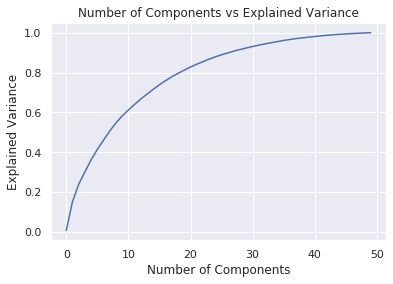

In [91]:
# We want to find the number of components that explains most of the variance
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Number of Components vs Explained Variance')

Looks like just 50 components is enough to explain 100% of the variance in the training set features. This means we have a lot of dependent features (i.e. some features are just linear combinations of other features). 


This is in line with what we saw in the feature selection section - even though we have 119 features, most techniques selected between 40-70 features (the remaining features might not be important since they are merely linear combinations of other features). 

In [92]:
# Lets go ahead and reduce dimensionality to 50

svd = TruncatedSVD(50)
train_featurse_decomposed = svd.fit_transform(train_features)
test_featurse_decomposed = svd.transform(test_features)

In [93]:
run_log_reg(train_featurse_decomposed, test_featurse_decomposed, y_train, y_test, alpha = 1e-1)

F1: 0.965 | Pr: 0.955 | Re: 0.975 | AUC: 0.993 | Accuracy: 0.964 



SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

The performance is not as good as the feature selection techniques. Why ? 

The main job of decomposition techniques, like TruncatedSVD, is to explain the variance in the dataset with fewer number of components. While doing this, it never considers the importance each feature had in predicting the target ('clickbait' or 'not-clickbait'). However, in the feature selection techniques, the feature importance or model weights is used each time a feature is removed or added. `RFE` and `SFS` in particular select features to optimize for model performance.  


* You might have noticied we pass 'y' in every `fit()` call in feature selection techniques. *

## Stacking Classifier with Feature Selection

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


batch_size = 128
epochs = 40

simple_nn = Sequential()
simple_nn.add(Dense(150, activation='relu', input_shape=(60,)))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid'))

simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('./saved_models', monitor = 'val_accuracy', verbose = 1, save_best_only=True)
history = simple_nn.fit(train_features_selected.todense(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint],
                    validation_data=(test_features_selected.todense(), y_test))

simple_nn = load_model('./saved_models')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 150)               9150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 24,351
Trainable params: 24,351
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 10000 samples
Epoch 1/40

Epoch 00001: val_accuracy improved from -inf to 0.58150, 

Epoch 33/40

Epoch 00033: val_accuracy did not improve from 0.97840
50/50 [==============================] - 0s 4ms/sample - loss: 0.0991 - accuracy: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.9783
Epoch 34/40

Epoch 00034: val_accuracy did not improve from 0.97840
50/50 [==============================] - 0s 4ms/sample - loss: 0.1124 - accuracy: 0.9800 - val_loss: 0.1073 - val_accuracy: 0.9780
Epoch 35/40

Epoch 00035: val_accuracy did not improve from 0.97840
50/50 [==============================] - 0s 3ms/sample - loss: 0.0674 - accuracy: 1.0000 - val_loss: 0.1029 - val_accuracy: 0.9777
Epoch 36/40

Epoch 00036: val_accuracy did not improve from 0.97840
50/50 [==============================] - 0s 4ms/sample - loss: 0.1023 - accuracy: 1.0000 - val_loss: 0.0986 - val_accuracy: 0.9778
Epoch 37/40

Epoch 00037: val_accuracy did not improve from 0.97840
50/50 [==============================] - 0s 3ms/sample - loss: 0.1002 - accuracy: 0.9600 - val_loss: 0.0947 - val_accuracy: 0.9777
Epoch

In [59]:
y_pred_prob = simple_nn.predict(test_features_selected.todense())
print_model_metrics(y_test, y_pred_prob)

F1: 0.979 | Pr: 0.973 | Re: 0.984 | AUC: 0.997 | Accuracy: 0.978 



In [72]:
# Define all models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log', alpha = 0.1, penalty = 'l2', l1_ratio = 0.5)
svm = SVC(C = 1, kernel = 'rbf', probability = True)
nb = MultinomialNB(alpha = 10000, class_prior = [0.5, 0.5])
knn = KNeighborsClassifier(n_neighbors = 31, weights = 'distance', n_jobs = -1)
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 2, max_depth = 15,  n_jobs = -1)
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.3, max_depth = 1, n_jobs = -1)

model_dict = dict(zip(['LR', 'SVM', 'NB', 'KNN', 'RF', 'XGB'], [lr, svm, nb, knn, rf, xgb]))

for model_name, model in model_dict.items():
    print('Training {}'.format(model_name))
    model.fit(train_features_selected, y_train)

model_weights = {'KNN': 0.7866810233035141,
                 'LR': 0.8036572275670447,
                 'NB': 0.9102009774357307,
                 'RF': 0.1559824350958057,
                 'SVM': 0.9355079606348642,
                 'XGB': 0.33469066125332436,
                 'simple_nn': 0.000545264707939086}


y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob)

Training LR
Training SVM
Training NB
Training KNN
Training RF
Training XGB
F1: 0.979 | Pr: 0.974 | Re: 0.984 | AUC: 0.997 | Accuracy: 0.979 



In [74]:
def run_voting_clf(model_weights):
    #result_list, model_weights = data
    
    y_pred_prob = 0

    for model_name, model in model_dict.items():
        y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

    #y_pred_prob += (simple_nn.get_preds(ds_type = DatasetType.Valid)[0].numpy()[:,0] * model_weights['simple_nn'])
    y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
    y_pred_prob /= sum(model_weights.values())
    f1 = print_model_metrics(y_test, y_pred_prob, return_metrics = True, verbose = 0)[0]
    return {'loss' : -f1, 'status' : STATUS_OK}

In [79]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        'LR' : hp.uniform('LR', 0, 1),
        'SVM' : hp.uniform('SVM', 0, 1),
        'NB' : hp.uniform('NB', 0, 1),
        'KNN' : hp.uniform('KNN', 0, 1),
        'RF' : hp.uniform('RF', 0, 1),
        'XGB' : hp.uniform('XGB', 0, 1),
        'simple_nn' : hp.uniform('simple_nn', 0, 1),


    },
    algo=tpe.suggest,
    max_evals=100,
    trials = trials)

100%|██████████| 100/100 [01:47<00:00,  1.08s/it, best loss: -0.9800717417297727]


In [80]:
model_weights

{'KNN': 0.37246470776176704,
 'LR': 0.8295308427606393,
 'NB': 0.6768543602714253,
 'RF': 0.007368733433434527,
 'SVM': 0.989277943052202,
 'XGB': 0.4017243064455823,
 'simple_nn': 0.6418257958346396}

F1: 0.980 | Pr: 0.976 | Re: 0.984 | AUC: 0.997 | Accuracy: 0.980 



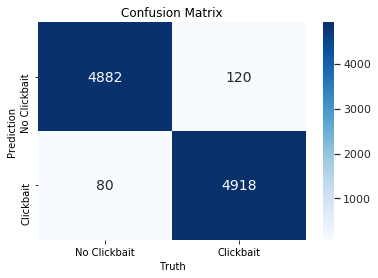

In [82]:
y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob, confusion = True)

In [86]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
    
#Find the threshold value that gives the best F1 Score
best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

# Calulcate predictions based on the threshold value
y_test_pred = np.where(y_pred_prob > best_threshold, 1, 0)
misclassified_idx = y_test != y_test_pred
high_confidence_indices = np.argsort(y_pred_prob[misclassified_idx])[-10:]

for idx in high_confidence_indices:
    print('Title : {}'.format(test[misclassified_idx].title.values[idx]))
    print('Label : {}'.format(test[misclassified_idx].label.values[idx]))
    print('Predicted Probability : {}'.format(y_pred_prob[misclassified_idx][idx]))
    print('-' * 10)

Title : A Peaking Tiger Woods
Label : not-clickbait
Predicted Probability : 0.7458264596039637
----------
Title : Stress Tests Prove a Sobering Idea
Label : not-clickbait
Predicted Probability : 0.7542456646954389
----------
Title : Woods Returns as He Left: A Winner
Label : not-clickbait
Predicted Probability : 0.7566487248241188
----------
Title : In Baseball, Slow Starts May Not Have Happy Endings
Label : not-clickbait
Predicted Probability : 0.7624898001334597
----------
Title : Ainge Has Heart Attack After Celtics Say Garnett May Miss Playoffs
Label : not-clickbait
Predicted Probability : 0.7784241132465458
----------
Title : Private Jets Lose That Feel-Good Factor
Label : not-clickbait
Predicted Probability : 0.7811035856329488
----------
Title : A Little Rugby With Your Cross-Dressing?
Label : not-clickbait
Predicted Probability : 0.7856236669189782
----------
Title : Smartphone From Dell? Just Maybe
Label : not-clickbait
Predicted Probability : 0.7868008600434597
----------
Tit

In [88]:
test[test.label.values == 'not-clickbait'].sample(10).title.values

array(['Wikileaks release Afghan "war logs" in co-operation with mainstream media',
       "Birmingham UK threat was 'real and very credible'",
       'News services and web companies increase Farsi services in light of Iranian political situation',
       'Jailed C.I.A. Mole Kept Spying for Russia, via Son, U.S. Says',
       'Chloroform spill forces evacuation of building at Canisius College in Buffalo, New York',
       'Iranian president calls Israel ‘disgraceful blot’',
       'W.H.O. Raises Alert Level as Flu Spreads to 74 Countries',
       '13,000 people participate in Bristol running event',
       'Trial Begins for Khmer Rouge Leader',
       'Citing Economy Worries, Argentine Leader Seeks Early Vote'],
      dtype=object)

## Tuning after Feature Selection

In [60]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)



# Since we want to use a predefined Test/Val set, we'll use PredefinedSplit and pass it as the CV parameter
# We need to merge both the datasets and label 0 for test and -1 for the train set

X = sparse.vstack((train_features_selected, test_features_selected))
test_fold = [-1 for _ in range(train_features_selected.shape[0])] + [0 for _ in range(test_features_selected.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = -1, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)

# Run log reg n times and average the metrics
def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    

from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log')
lr_params = {'alpha' : [10**(-x) for x in range(7)],
             'penalty' : ['l1', 'l2', 'elasticnet'],
             'l1_ratio' : [0.15, 0.25, 0.5, 0.75]}

best_params, best_f1 = run_grid_search(lr, lr_params, X, y)

print('LR Best Parameters : {}'.format(best_params))



from sklearn.svm import SVC

svm = SVC(probability = True)
svm_params = {'C' : [10**(x) for x in range(-1,4)],
             'kernel' : ['poly', 'rbf', 'linear'],
             'degree' : [2, 3]}

best_params, best_f1 = run_grid_search(svm, svm_params, X, y)

print('SVM Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(class_prior = [0.5, 0.5])
nb_params = {'alpha' : [10**(x) for x in range(6)]}


best_params, best_f1 = run_grid_search(nb, nb_params, X, y)

print('NB Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs = -1)

knn_params = { 'n_neighbors' : [3, 5, 7, 9, 15, 31], 
               'weights' : ['uniform', 'distance']
}

best_params, best_f1 = run_grid_search(knn, knn_params, X, y)
print('KNN Best Parameters : {}'.format(best_params))

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs = -1)

rf_params = { 'n_estimators' : [10, 100, 250, 500, 1000], 
               'max_depth' : [None, 3, 7, 15],
               'min_samples_split' : [2, 5, 15]
}

best_params, best_f1 = run_grid_search(rf, rf_params, X, y)

print('RF Best Parameters : {}'.format(best_params))

from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs = 1)

xgb_params = { 'n_estimators' : [10, 100, 200, 500], 
               'max_depth' : [1, 2, 3, 7],
               'learning_rate' : [0.1, 0.2, 0.01, 0.3],
               'reg_alpha' : [0, 0.1, 0.2]
}

best_params, best_f1 = run_grid_search(xgb, xgb_params, X, y)

print('XGB Best Parameters : {}'.format(best_params))